In [1]:
%matplotlib inline 

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation
from matplotlib.colors import Normalize, to_rgb
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import lambertw
from scipy.special import gamma
from PIL import Image
from functools import reduce

In all calculations, $m$ and $\hbar$ are assumed to be 1.

In [2]:
def Superpos_1D(func, x, t, coeff, qn, param=None):
    param = {} if param is None else param
    norm = np.linalg.norm(coeff)
    return np.sum([c * func(x, t, n, **param) for c,n in zip(coeff, qn)], axis=0) / norm

def Superpos_2D(func, x, y, t, coeff, qn, param=None):
    param = {} if param is None else param
    norm = np.linalg.norm(coeff)
    return np.sum([c * func(x, y, t, qn, **param) for c, qn in zip(coeff, qn)], axis=0) / norm

def Superpos_Period(energy_func, qn, param={}, epsilon=1e-5):
    def gcd(a, b):
        while b > epsilon:
            t, b = b, a % b
            a = t
        return a
    def gcd_list(ls):
        return reduce(gcd, ls)
    
    qn = np.asarray(qn)
    energies = energy_func(qn[...,0], qn[...,1], **param)
    energy_gcd = gcd_list(energies)
    return 2 * np.pi / energy_gcd

In [3]:
# Infinite Square Well

# 1D Energy Eigenstate
def ISW_Eigenstate_1D_Energy_Factor(L=1):
    return np.pi * np.pi / (2 * L*L)
def ISW_Eigenstate_1D_Energy(n, L=1):
    return ISW_Eigenstate_1D_Energy_Factor(L) * n*n
def ISW_Eigenstate_1D(x, t, n, L=1):
    x = np.array(x, dtype=complex)
    inside = lambda z: np.sqrt(2/L)*np.sin(n * np.pi * z / L)*np.exp(-1j * t * ISW_Eigenstate_1D_Energy(n))
    outside = lambda z: 0
    return np.piecewise(x, [(np.real(x) >= 0) * (np.real(x) <= L), (np.real(x) < 0) + (np.real(x) > L)], [inside, outside])

# 2D Energy Eigenstate
def ISW_Eigenstate_2D_Energy(n, m, Ls=(1,1)):
    return 0.5 * np.pi*np.pi * ((n**2 / Ls[0]**2) + (m**2 / Ls[1]**2))
def ISW_Eigenstate_2D(x, y, t, ns, Ls=(1,1)):
    n_x, n_y = ns
    L_x, L_y = Ls
    return ISW_Eigenstate_1D(x, t, n_x, L_x) * ISW_Eigenstate_1D(y, t, n_y, L_y)


# Superposition periods
def ISW_Superpos_1D_period(qn, L=1):
    return 4 * L*L / (np.pi * np.gcd.reduce([n*n for n in qn]))

def ISW_Superpos_2D_period(quantum_numbers, L_x=1, L_y=1):
    return 4 * L_x*L_x * L_y*L_y / (np.pi * np.gcd.reduce([n*n*L_y*L_y + m*m*L_x*L_x for n,m in quantum_numbers]))

In [4]:
# Free Particle

# 1D free gaussian wave packet
def Free_Gaussian_1D(x, t, sigma, k):
    zeta = lambda t: t - 2j * sigma * sigma
    f1 = lambda t: np.sqrt(zeta(0) / (np.sqrt(2*np.pi) * sigma * zeta(t)))
    f2 = lambda x, t: np.exp(1j * (x - k*t)**2 / (2 * zeta(t)))
    f3 = lambda x, t: np.exp(1j * k * (x - k * t / 2))
    return f1(t) * f2(x, t) * f3(x, t)

# 2D free gaussian wave packet
def Free_Gaussian_2D(x, y, t, sigmas, ks):
    sigma_x, sigma_y = sigmas
    k_x, k_y = ks
    return Free_Gaussian_1D(x, t, sigma_x, k_x) * Free_Gaussian_1D(y, t, sigma_y, k_y)

In [5]:
# Harmonic Oscillator

# store Hermite polynomial coefficients for re-use
Hermite_Coeff_dict = {0:[1]}

# 1D Energy Eigenstate
def HO_Eigenstate_1D(x, t, n, omega=1):
    def diff_polynomial(coeff):
        return [0] if len(coeff) == 1 else [i*coeff[i] for i in range(1, len(coeff))]
    def mult_by_minus2x(coeff):
        return [-2*x for x in [0] + coeff]
    def add_polynomials(coeff1, coeff2):
        if len(coeff2) > len(coeff1):
            coeff1, coeff2 = coeff2, coeff1
        for i in range(len(coeff2)):
            coeff1[i] += coeff2[i]
        return coeff1
    def hermite_coeff(n):
        if n not in Hermite_Coeff_dict:
            prev = hermite_coeff(n-1)
            Hermite_Coeff_dict[n] = add_polynomials(diff_polynomial(prev), mult_by_minus2x(prev))
        return Hermite_Coeff_dict[n]
    def evaluate_poly(x, coeff):
        return sum([coeff[i]*(x**i) for i in range(len(coeff))])
    
    coeff = 1 / np.sqrt((2**n) * gamma(n+1) * np.sqrt(np.pi / omega))
    gauss = np.exp(-1 * omega * x**2 / 2)
    phase = np.exp(-1j * omega * (n + 0.5) * t)
    herm = evaluate_poly(x * np.sqrt(omega), hermite_coeff(n))
    
    return coeff * gauss * phase * herm

# 2D Energy Eigenstate
def HO_Eigenstate_2D_Energy(n, m, omegas=(1,1)):
    return omegas[0] * (n + 0.5) + omegas[1] * (m + 0.5)
def HO_Eigenstate_2D(x, y, t, ns, omegas=(1,1)):
    n_x, n_y = ns
    omega_x, omega_y = omegas
    return HO_Eigenstate_1D(x, t, n_x, omega_x) * HO_Eigenstate_1D(y, t, n_y, omega_y)


# Superposition periods
def HO_Superpos_1D_period(qn, omega=1):
    return 4 * np.pi / (omega * np.gcd.reduce([2*n + 1 for n in qn]))

def HO_Superpos_2D_period(quantum_numbers, omega_x=1, omega_y=1):
    return 4 * np.pi / np.gcd.reduce([omega_x*(2*n + 1) + omega_y*(2*m + 1) for n,m in quantum_numbers])

# 1D Coherent State (defualt 10 terms in sum)
def HO_Coherent_State_1D(x, t, alpha, omega=1, num_components=10):
    qns = np.arange(num_components)
    coeff = np.power(alpha, qns) * np.exp(-1 * np.abs(alpha)**2 / 2) / np.sqrt(gamma(qns+1))
    return Superpos_1D(HO_Eigenstate_1D, x, t, coeff, qns, {'omega':omega})

# 2D Coherent State
def HO_Coherent_State_2D(x, y, t, alphas, omegas=(1,1), num_components=10):
    alpha_x, alpha_y = alphas
    omega_x, omega_y = omegas
    return HO_Coherent_State_1D(x, t, alpha_x, omega_x, num_components) * HO_Coherent_State_1D(y, t, alpha_y, omega_y, num_components)

In [6]:
# Double Delta Well

# Even-state wave number
def even_kappa(beta, L):
    return beta + lambertw(beta*L*np.exp(-1*beta*L)) / L

# Odd-state wave number
def odd_kappa(beta, L):
    return beta + lambertw(-1*beta*L*np.exp(-beta*L)) / L

# Even-state energy
def even_energy(beta, L):
    return -0.5 * even_kappa(beta, L)**2

# Odd-state energy
def odd_energy(beta, L):
    return -0.5 * odd_kappa(beta, L)**2

# Even Energy Eigenstate
def DD_Even_Eigenstate_1D(x, t, beta, L):
    x = np.array(x, dtype=complex)
    k = even_kappa(beta, L)
    a_1 = np.sqrt(2*k) * np.cosh(0.5*k*L) / np.sqrt(1 + (1+(k*L))*np.exp(-1*k*L))
    a_2 = a_1 * np.exp(-0.5*k*L) / (2 * np.cosh(0.5*k*L))
    phase = np.exp(-1j * even_energy(beta, L) * t)
    region1 = lambda x: a_1 * np.exp(k * x) * phase
    region2 = lambda x: a_2 * 2 * np.cosh(k*x) * phase
    region3 = lambda x: a_1 * np.exp(-1*k*x) * phase
    return np.piecewise(x, [x < -0.5*L, (x >= -0.5*L) & (x < 0.5*L), x >= 0.5*L], [region1, region2, region3])

# Odd Energy Eigenestate
def DD_Odd_Eigenstate_1D(x, t, beta, L):
    x = np.array(x, dtype=complex)
    k = odd_kappa(beta, L)
    a_1 = np.sqrt(2*k) * np.sinh(0.5*k*L) / np.sqrt(1 - (1+(k*L))*np.exp(-k*L))
    a_2 = a_1 * np.exp(-0.5*k*L) / (2 * np.sinh(0.5*k*L))
    phase = np.exp(-1j * odd_energy(beta, L) * t)
    region1 = lambda x: a_1 * np.exp(k*x) * phase
    region2 = lambda x: -2 * a_2 * np.sinh(k*x) * phase
    region3 = lambda x: -1 * a_1 * np.exp(-1*k*x) * phase
    return np.piecewise(x, [np.real(x) < -0.5*L, (np.real(x) >= -0.5*L) & (np.real(x) < 0.5*L), np.real(x) >= 0.5*L], [region1, region2, region3])

# Superposition of even/odd eigenstates
def DD_Superpos_1D(x, t, even_coeff, odd_coeff, beta, L):
    norm = np.sqrt(np.abs(even_coeff)**2 + np.abs(odd_coeff)**2)
    return (even_coeff * DD_Even_Eigenstate_1D(x, t, beta, L) + odd_coeff * DD_Odd_Eigenstate_1D(x, t, beta, L)) / norm

In [7]:
# Attempt to test the free-particle to ISW transform
def Free_to_ISW(x, t, freeWave, L=1, jmax=1000):
    return sum([freeWave(x + 2*i*L, t) - freeWave(x - 2*i*L, t) for i in range(-jmax, jmax+1)])

In [8]:
def Make_Axis_Labels(x_range, y_range, acc, num_labels):
    # Stole this from a stack exchange post...gonna have to find that...
    nx = int(np.abs(x_range[1] - x_range[0]) / acc)
    ny = int(np.abs(y_range[1] - y_range[0]) / acc)
    xs = np.linspace(*x_range, nx)
    ys = np.flip(np.linspace(*y_range, ny))
    step_x = int(nx / (num_labels - 1)) # step between consecutive labels
    step_y = int(ny / (num_labels - 1))
    x_positions = np.append(np.arange(0,nx,step_x), nx-1) # pixel count at label position
    y_positions = np.append(np.arange(0,ny,step_y), ny-1)
    x_labels = ["{:.2f}".format(a) for a in np.append(xs[::step_x], xs[-1])] # labels you want to see
    y_labels = ["{:.2f}".format(a) for a in np.append(ys[::step_y], ys[-1])]
    return x_labels, x_positions, y_labels, y_positions

# Plot 1D wavefunction
# Args
## wavefunc: a complex function of x and t
## x_range:  the range of x values to plot
## acc:      the accuracy to use
## options:  various plotting options:
###     -cmap:    the colormap to use for phase (default is hsv)
###     -y_range: the range of y values to plot (default is max produced by function over the x_range)
###     -title:   the title to use for the graph
###     -xlabel: the x-axis label
###     -ylabel: the y-axis label
def Plot_Wavefunction_1D(wavefunc, x_range, acc, options={}):
    x_range = np.array(x_range)
    n_sample = int((x_range[1]-x_range[0])/acc)
    x = np.linspace(x_range[0], x_range[1], n_sample)
    y = np.abs(wavefunc(x))
    z = (np.angle(wavefunc(x)) + np.pi) / (2 * np.pi)
    plt.clf()
    cmap = options["cmap"] if "cmap" in options else cm.hsv
    if "y_range" in options:
        plt.ylim(*options["y_range"])
    if "title" in options:
        plt.title(options["title"])
    if "xlabel" in options:
        plt.xlabel(options["xlabel"])
    if "ylabel" in options:
        plt.ylabel(options["ylabel"])
    if "colorbar" in options and options["colorbar"]:
        norm = Normalize(vmin=0, vmax=2)
        plt.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap), label=r"$\arg(\Psi)\:mod\:\pi$")
    plt.plot(x, y)
    for i in range(n_sample-1):
        plt.fill_between([x[i], x[i+1]], [y[i], y[i+1]], color=cmap(z[i]))
        
# Plot 2D Image of a 2D Wavefunction
# Args:
## wavefunc: a complex function of x, y and t
## x_range:  the range of x values to plot
## y_range:  the range of y values to plot
## acc:      the accuracy to use
## options:  various plotting options:
###     -cmap:    the color map to use for phase
###     -title:   the title to use for the graph
###     -axis-on: True iff the axis should be on
# getting axis labels while using imshow: https://stackoverflow.com/questions/18696122/change-values-on-matplotlib-imshow-graph-axis
def Plot_Wavefunction_2D_Image(wavefunc, x_range, y_range, acc, options={}, norm=None):
    x_range = np.array(x_range)
    y_range = np.array(y_range)
    X,Y = np.mgrid[x_range[0]:x_range[1]:acc, y_range[0]:y_range[1]:acc]
    vals = wavefunc(X,Y)
    mag = np.abs(vals)
    norm = mag.max() if norm is None else norm
    mag = mag / norm
    phase = (np.angle(vals) + np.pi) / (2 * np.pi)
    cmap = options["cmap"] if "cmap" in options else cm.hsv
    arr = cmap(phase)
    arr = np.insert(arr[:,:,:3], 3, mag, axis=2)
    plt.clf()
    # make axis labels
    x_labels, x_positions, y_labels, y_positions = Make_Axis_Labels(x_range, y_range, acc, 5)
    plt.xticks(x_positions, x_labels)
    plt.yticks(y_positions, y_labels)
    if not ("axis-on" in options) or not options["axis-on"]:
        plt.axis('off')
    if "title" in options:
        plt.title(options["title"])
    if "xlabel" in options:
        plt.xlabel(options["xlabel"])
    if "ylabel" in options:
        plt.ylabel(options["ylabel"])
    if "colorbar" in options and options["colorbar"]:
        norm = Normalize(vmin=0, vmax=2)
        plt.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap), label=r"$\arg(\Psi)\:mod\:\pi$")
    plt.imshow(arr)
    
def Plot_Wavefunction_2D_Graph(wavefunc, x_range, y_range, acc, options={}):
    x_range = np.array(x_range)
    y_range = np.array(y_range)
    x = np.arange(*x_range, acc)
    y = np.arange(*y_range, acc)
    X,Y = np.meshgrid(x,y)
    vals = wavefunc(X,Y)
    Z = np.abs(vals)
    phase = (np.angle(vals) + np.pi) / (2 * np.pi)
    cmap = options["cmap"] if "cmap" in options else cm.hsv
    norm = Normalize(vmin=0, vmax=2)
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    m.set_array([])
    fcolors = m.to_rgba(phase)
    plt.clf()
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=fcolors, shade=False)
    
def Plot_Wavefunction_2D_Image_on_axis(wavefunc, x_range, y_range, acc, options, axis, norm=None):
    # Clear axis
    axis.clear()
    
    # Genrate x-y points
    X,Y = np.mgrid[x_range[0]:x_range[1]:acc, y_range[0]:y_range[1]:acc]
    
    # Evaluate wavefunction
    vals = wavefunc(X,Y)
    
    # Get magnitude for each sample point, then normalize
    mag = np.abs(vals)
    mag = mag / np.amax(mag)
    
    # Get the phases for each sample point, convert to color using cmap
    phase = (np.angle(vals) + np.pi) / (2 * np.pi)
    cmap = options["cmap"] if "cmap" in options else cm.hsv
    arr = cmap(phase)
    # Set the alpha channel for each sample to the normalized magnitude
    arr = np.insert(arr[:,:,:3], 3, mag, axis=2)
    
    ## Plot options
    if "axis-on" in options and options["axis-on"]:
        print("AXIS IS ON")
        x_labels, x_positions, y_labels, y_positions = Make_Axis_Labels(x_range, y_range, acc, options["num_labels"])
        if "xlabel-on" in options and options["xlabel-on"]:
            axis.set_xticks(x_positions)
            axis.set_xticklabels(x_labels)
        if "ylabel-on" in options and options["ylabel-on"]:
            axis.set_yticks(y_positions)
            axis.set_yticklabels(y_labels)
    else:
        axis.axis('off')
    if "title" in options:
        axis.set_title(options["title"])
    
    # Plot data
    axis.imshow(arr)
              
def Plot_Wavefunction_2D_Images(wavefuncs, x_ranges, y_ranges, accs, shape, axis_options, axarr):
    rows, cols = shape
    for r in range(rows):
        for c in range(cols):
            Plot_Wavefunction_2D_Image_on_axis(wavefuncs[r,c], x_ranges[r,c], y_ranges[r,c], accs[r,c], axis_options[r,c], axarr[r,c])


In [9]:
def Wavefunction_Animation_1D(f, acc, x_range, t_range, frames, fname, plot_options={}, fps=30):
    xs = np.arange(*x_range, acc)
    ts = np.linspace(*t_range, frames, endpoint=False)
    max_f = max([np.abs(f(x, t)) for x in xs for t in ts])
    plot_options["y_range"] = [0, max_f]
    def animf(i):
        g = lambda x: f(x, ts[i])
        Plot_Wavefunction_1D(g, x_range, acc, plot_options)
        
    fig = plt.figure()
    anim = animation.FuncAnimation(fig, animf, frames=frames)
    anim.save(fname, fps=fps)
    
def Wavefunction_Animation_2D_Image(f, acc, x_range, y_range, t_range, plot_options, anim_options):
    fname = anim_options["filename"]
    frames = anim_options["frames"]
    fps = anim_options["fps"]
    dpi = anim_options["dpi"]
    norm_by_frame = plot_options["norm_by_frame"]
    ts = np.linspace(*t_range, frames, endpoint=False)
    
    if not norm_by_frame:
        print("Calculating global norm...")
        X,Y = np.mgrid[x_range[0]:x_range[1]:acc, y_range[0]:y_range[1]:acc]
        norm = np.max([np.abs(f(X,Y,t)) for t in ts])
    
    figsize = (plot_options["figsize-factor"], plot_options["figsize-factor"])
    fig, ax = plt.subplots(figsize=figsize)
    
    def animf(i):
        print("Frame: ", i)
        g = lambda x,y: f(x, y, ts[i])
        Plot_Wavefunction_2D_Image_on_axis(g, x_range, y_range, acc, plot_options, ax, (norm if not norm_by_frame else None))
        
    print("Begining frame compilation...")
    anim = animation.FuncAnimation(fig, animf, frames=frames)
    anim.save(fname, fps=fps, dpi=200)
    
                    
"""    
graph_options = {"accs": None,
                 "x_ranges": None,
                 "y_ranges": None,
                 "t_ranges": None
}
plot_options = {"shape": None,
                "colormap": cm.hsv,
                "figsize-factor":4,
                "sharex": False,
                "colorbar-on":False
}
axis_options = {"title": "",
                "axis-on": False,
                "xlabel-on": False,
                "ylabel-on":False,
                "num_labels": 5
}
anim_options = {"frames": 120,
                "fps": 30,
                "filename": "foo.mp4",
                "dpi": 200
} """
#if "colorbar" in options and options["colorbar"]:
        #norm = Normalize(vmin=0, vmax=2)
        #plt.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap), label=r"$\arg(\Psi)\:mod\:\pi$")
def Wavefunction_Animation_2D_Images(funcs, graph_options, plot_options, axis_options, anim_options):
    # Ensure numpy arrays
    shape = np.asarray(plot_options["shape"])
    axis_options = np.reshape(np.asarray(axis_options), shape)
    funcs = np.reshape(np.asarray(funcs), shape)
    accs = np.reshape(np.asarray(graph_options["accs"]), shape)
    x_ranges = np.reshape(np.asarray(graph_options["x_ranges"]), np.append(shape, 2))
    y_ranges = np.reshape(np.asarray(graph_options["y_ranges"]), np.append(shape, 2))
    t_ranges = np.reshape(np.asarray(graph_options["t_ranges"]), np.append(shape, 2))
    
    times = np.linspace(t_ranges[...,0], t_ranges[...,1], anim_options["frames"], endpoint=False)
    
    figsize = shape * plot_options["figsize-factor"]
    fig, axarr = plt.subplots(*shape, squeeze=False, figsize=figsize)
    
    apply_time = np.vectorize(lambda f, t: lambda x, y: f(x, y, t))
    def animf(i):
        gs = apply_time(funcs, times[i])
        Plot_Wavefunction_2D_Images(gs, x_ranges, y_ranges, accs, shape, axis_options, axarr)
        plt.show()
        
    anim = animation.FuncAnimation(fig, animf, frames=anim_options["frames"])
    anim.save(anim_options["filename"], fps=anim_options["fps"])

In [10]:
# 1D Infinite Square Well
fname = "1D_ISW_Test.mp4"
qn = [1, 2]
coeff = [1, -1j]
wavefunc = lambda x, t: Superpos_1D(ISW_Eigenstate_1D, x, t, coeff, qn)
x_range = [0, 1]
t_range = [0, 4 / np.pi]
acc = 0.01
frames = 180
plot_options = {
    "title": "Infinite Square Well Test",
    "xlabel": r"$x/L$",
    "ylabel": r"$|\Psi|$",
    "colorbar":True
}

#Wavefunction_Animation_1D(wavefunc, acc, x_range, t_range, frames, fname, plot_options)

In [11]:
# 2D Infinite Square Well
qn = [(1,1), (2, 2), (4,4)]
coeff = [1, -1j, -1]
wavefunc = lambda x, y, t: Superpos_2D(ISW_Eigenstate_2D, x, y, t, coeff, qn)
x_range = [0, 1]
y_range = [0, 1]
t_range = [0, Superpos_Period(ISW_Eigenstate_2D_Energy, qn)]
acc = 1/128
plot_options = {
    "title": r"$\Psi_{1,1} + \Psi_{2,2} + \Psi_{4,4}$",
    "axis-on": True, 
    "xlabel": r"$x/L_x$",
    "ylabel": r"$y/L_y$",
    "colorbar": True,
    "axis-on": False,
    "norm_by_frame": False
}
anim_options = {
    "filename": "2D_ISW_Period_test.mp4",
    "frames": 1,
    "fps": 30,
    "dpi": 200
}

#Wavefunction_Animation_2D_Image(wavefunc, acc, x_range, y_range, t_range, plot_options, anim_options)

In [12]:
# 1D Free Particle
fname = "1D_Free_Particle_Test.mp4"
sigma = 1
k = 1
wavefunc = lambda x, t: Free_Gaussian_1D(x, t, sigma, k)
x_range = [-10, 10]
t_range = [0, 2*np.pi]
acc = 10/128
frames = 60
plot_options = {
    "title": "1D Free Particle Test", 
    "axis-on": True,
    "xlabel": r"$x$",
    "ylabel": r"$y$",
    "colorbar": True}

#Wavefunction_Animation_1D(wavefunc, acc, x_range, t_range, frames, fname, plot_options)

In [13]:
# 2D Free Particle
sigmas = (1, 1)
ks = (1, -1)
wavefunc = lambda x, y, t: Free_Gaussian_2D(x, y, t, sigmas, ks)
x_range = [-10, 10]
y_range = [-10, 10]
t_range = [0, np.pi]
acc = 10/128
frames = 60
plot_options = {
    "title": "1D Free Particle Test",
    "axis-on": True,
    "xlabel": r"$x$",
    "ylabel": r"$y$",
    "colorbar": True,
    "axis-on": False,
    "norm_by_frame": False
}
anim_options = {
    "filename": "2D_Free_Particle_Test.mp4",
    "frames": 1,
    "fps": 30,
    "dpi": 200
}

#Wavefunction_Animation_2D_Image(wavefunc, acc, x_range, y_range, t_range, plot_options, anim_options)

In [14]:
# Free-to-ISW test
fname = "Free-to-ISW_test.mp4"
sigma = 0.5
k = 1
x0 = 0.5
jmax = 1000
freeWave = lambda x, t: Free_Gaussian_1D(x-x0, t, sigma, k)
wavefunc = lambda x, t: Free_to_ISW(x, t, freeWave, jmax)
x_range = [0, 1]
t_range = [0, np.pi/8]
acc = 1/128
frames = 30
plot_options = {"title":"Free Particle to ISW Test", "axis-on":True, "xlabel":r"$x$", "ylabel":r"$y$", "colorbar":True}
#Wavefunction_Animation_1D(wavefunc, acc, x_range, t_range, frames, fname, plot_options)

In [15]:
# 1D Harmonic Oscillator
fname = "1D_HO_Test.mp4"
qn = [1, 2]
coeff = [1, 1]
wavefunc = lambda x, t: Superpos_1D(HO_Eigenstate_1D, x, t, coeff, qn)
x_range = [-5, 5]
t_range = [0, 2*np.pi]
acc = 1/128
frames = 60
plot_options = {
    "title":"1D Harmonic Oscillator Test",
    "axis-on": True,
    "xlabel": r"$x$",
    "ylabel": r"$y$",
    "colorbar": True
}

#Wavefunction_Animation_1D(wavefunc, acc, x_range, t_range, frames, fname, plot_options)

MovieWriter ffmpeg unavailable; using Pillow instead.


Begining frame compilation...
Frame:  0
Frame:  0
Frame:  1
Frame:  2
Frame:  3
Frame:  4
Frame:  5
Frame:  6
Frame:  7
Frame:  8
Frame:  9
Frame:  10
Frame:  11
Frame:  12
Frame:  13
Frame:  14
Frame:  15
Frame:  16
Frame:  17
Frame:  18
Frame:  19
Frame:  20
Frame:  21
Frame:  22
Frame:  23
Frame:  24
Frame:  25
Frame:  26
Frame:  27
Frame:  28
Frame:  29
Frame:  30
Frame:  31
Frame:  32
Frame:  33
Frame:  34
Frame:  35
Frame:  36
Frame:  37
Frame:  38
Frame:  39
Frame:  40
Frame:  41
Frame:  42
Frame:  43
Frame:  44
Frame:  45
Frame:  46
Frame:  47
Frame:  48
Frame:  49
Frame:  50
Frame:  51
Frame:  52
Frame:  53
Frame:  54
Frame:  55
Frame:  56
Frame:  57
Frame:  58
Frame:  59


ValueError: unknown file extension: .mp4

Frame:  0


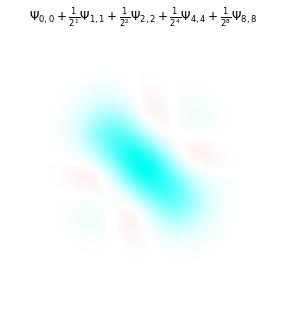

In [18]:
# 2D Harmonic Oscillator 
quantum_numbers = [(0,0), (1,1), (2,2)]
coeff = [1, 1/2, 1/4]
x_range = [-5,5]
y_range = x_range
omegas = (1,2)
t_range = [0, Superpos_Period(HO_Eigenstate_2D_Energy, quantum_numbers)]
acc = 1/256

wavefunc = lambda x, y, t: Superpos_2D(HO_Eigenstate_2D, x, y, t, coeff, quantum_numbers)
plot_options = {
    "title": r"$\Psi_{0,0} + \frac{1}{2^1}\Psi_{1,1} + \frac{1}{2^2}\Psi_{2,2} + \frac{1}{2^4}\Psi_{4,4} + \frac{1}{2^8}\Psi_{8,8}$",
    "axis-on": True,
    "xlabel": r"$x/x_s$",
    "ylabel": r"$y/y_s$",
    "colorbar": True,
    "axis-on": False,
    "figsize-factor": 5,
    "norm_by_frame": True
}
anim_options = {
    "filename": "2D_HO_period_test_global_norm.mp4",
    "frames": 60,
    "fps": 30,
    "dpi": 200
}

Wavefunction_Animation_2D_Image(wavefunc, acc, x_range, y_range, t_range, plot_options, anim_options)

In [17]:
# 1D Harmonic Oscillator Coherent State
fname = "1D_Coherent_State_Test_9.mp4"
alpha = 1
omega = 1
num_components = 9
wavefunc = lambda x, t: HO_Coherent_State_1D(x, t, alpha, omega, num_components)
x_range = [-7, 7]
t_range = [0, 4*np.pi]
acc = 14/128
frames = 60
plot_options = {
    "title": "1D Coherent State Approximation (9 terms)",
    "axis-on": True,
    "xlabel": r"$x/x_s$",
    "ylabel": r"$|\Psi|$",
    "colorbar": True
}

#Wavefunction_Animation_1D(wavefunc, acc, x_range, t_range, frames, fname, plot_options)

In [18]:
# 2D Harmonic Oscillator Coherent State
alphas = (1, 1j)
num_components = 10
wavefunc = lambda x, y, t: HO_Coherent_State_2D(x, y, t, alphas)
x_range = [-5, 5]
y_range = [-5, 5]
t_range = [0, 2*np.pi]
acc = 5/128
frames = 90
plot_options = {
    "title": "2D Coherent State Test",
    "axis-on": True,
    "xlabel": r"$x/L_x$",
    "ylabel": r"$y/L_y$",
    "colorbar": True,
    "axis-on": False,
    "norm_by_frame": False
}
anim_options = {
    "filename": "2D_Coherent_State_Test.mp4",
    "frames": 90,
    "fps": 30,
    "dpi": 200
}

#Wavefunction_Animation_2D_Image(wavefunc, acc, x_range, y_range, t_range, plot_options, anim_options)

In [19]:
fname = "1D_double_well_test2.mp4"
acc = 1/128
beta = 2
L = 1
x_range = [-2, 2]
t_range = [0, 2 * np.pi / (odd_energy(beta, L) - even_energy(beta, L))]
wavefunc = lambda x, t: DD_Superpos_1D(x, t, 1, 1, beta, L)
acc = 1/128
frames = 90
plot_options = {"title":r"1D Double Delta-Well ($\beta=2, L=1$)", "axis-on":True, "xlabel":r"$x/L$", "ylabel":r"$|\Psi|$", "colorbar":True}

#Wavefunction_Animation_1D(wavefunc, acc, x_range, t_range, frames, fname, plot_options)

In [20]:
def make_time_ranges(endpoints, start=0):
    return [(start, x) for x in endpoints]

shape = (2,2)
n = shape[0]*shape[1]

qn00 = [(11,12),(13,11)]
qn01 = [(12,9), (13,12)]
qn10 = [(11,10), (12,12)]
qn11 = [(11,8), (12,13)]
T00 = ISW_Superpos_2D_period(qn00)
T01 = ISW_Superpos_2D_period(qn01)
T10 = ISW_Superpos_2D_period(qn10)
T11 = ISW_Superpos_2D_period(qn11)

f00 = lambda x,y,t: Superpos_2D(ISW_Eigenstate_2D, x, y ,t, [1,1], qn00)
f01 = lambda x,y,t: Superpos_2D(ISW_Eigenstate_2D, x, y, t, [1,-1j], qn01)
f10 = lambda x,y,t: Superpos_2D(ISW_Eigenstate_2D, x, y, t, [1, 1j], qn10)
f11 = lambda x,y,t: Superpos_2D(ISW_Eigenstate_2D, x, y, t, [1, -1], qn11)
funcs = [f00, f01, f10, f11]
title00 = r"$\Psi_{11,12}+\Psi_{13,11}$"
title01 = r"$\Psi_{12,9}-i\Psi_{13,12}$"
title10 = r"$\Psi_{11,10} + i\Psi_{12,12}$"
title11 = r"$\Psi_{11,8}-\Psi_{12,13}$"


x_ranges = [(0,1)] * n
axis_options = [{'title':title00}, {'title':title01}, {'title':title10}, {'title':title11}]

graph_options = {"accs": [.005] * n,
                 "x_ranges": list(x_ranges),
                 "y_ranges": list(x_ranges),
                 "t_ranges": make_time_ranges([T00, T01, T10, T11])
}
plot_options = {"shape": (2,2),
                "colormap": cm.hsv,
                "figsize-factor": 8,
                "sharex": False,
                "colorbar-on": False,
                "axis-on": False,
                "norm_by_frame": True
}
anim_options = {"frames": 3000,
                "fps": 30,
                "filename": "new_split_test.mp4",
                "dpi": 200
}


#Wavefunction_Animation_2D_Images(funcs, graph_options, plot_options, axis_options, anim_options)

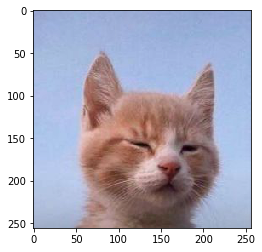

In [21]:
def get_value_from_hsv_color(color):
    colrange = [0.,1.]
    color = to_rgb(color)
    n = 10000
    r = np.linspace(0,1,n)
    norm = Normalize(0,1)
    mapvals = cmap(np.linspace(0,1,n))[:,:3]
    distance = np.sum((mapvals - color)**2, axis=1)
    return r[np.argmin(distance)]

cmap = cm.hsv
rmap = cmap.reversed()
im = Image.open("cat_256.png")
im.convert('RGB')
rgb_data = np.reshape(np.array(im.getdata())[...,:-1], (*im.size, 3))
mins = np.reshape(rgb_data.min(axis=-1), (*rgb_data.shape[:-1], 1))
alphas = (255 - mins) / 255
shifted_data = rgb_data - mins
scaled_data = (shifted_data / (255 * alphas))
ones = np.ones((*im.size, 1))
scaled_data_with_ones = np.append(scaled_data, ones, axis=-1)
phase_data = 2 * np.pi * np.apply_along_axis(get_value_from_hsv_color, -1, scaled_data_with_ones) - np.pi

complex_vals = np.multiply(alphas.squeeze(), np.exp(1j * phase_data))
rgba_data = np.append(scaled_data, alphas, axis=-1)
plt.imshow(rgba_data)

In [22]:
acc = 1/im.size[0]
X,Y = np.mgrid[0:1:acc, 0:1:acc]
qn = []
coeff = []
max_n = im.size[0]
for i in range(1, max_n + 1):
    for j in range(1, max_n + 1):
        f = lambda x,y: ISW_Eigenstate_2D(x, y, 0, (i,j))
        prod = f(X,Y) * complex_vals
        coeff.append(prod.sum())
        qn.append((i,j))

In [33]:
indexed_coeff = sorted(list(zip(qn, coeff)), key=lambda x: x[1], reverse=True)
cutoff = 0.5
skim_coeff = [indexed_coeff.pop()]
norm = sum(np.abs(coeff))
s = np.abs(skim_coeff[0][1])
for i in range(len(indexed_coeff)):
    if s / norm >= cutoff:
        break
    next_coeff = indexed_coeff[i]
    skim_coeff.append(next_coeff)
    s += np.abs(next_coeff[1])

In [34]:
qn_less, coeff_less = zip(*skim_coeff)
print(len(coeff))
print(len(coeff_less))
print(qn_less[10])
print(coeff_less[10])

65536
11802
(1, 12)
(2339.7319912857038+681.5475789364102j)


In [35]:
def iterative_2D_superpos(func, x, y, t, coeff, qn):
    norm = 0
    for c in coeff:
        norm += np.abs(c)**2
    norm = np.sqrt(norm)
    res = 0
    for i in range(len(coeff)):
        res = res + coeff[i] * func(x, y, t, qn[i])
    return res / norm

6.283185307179586
Begining frame compilation...
Frame:  0


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in multiply


AttributeError: 'int' object has no attribute 'arctan2'

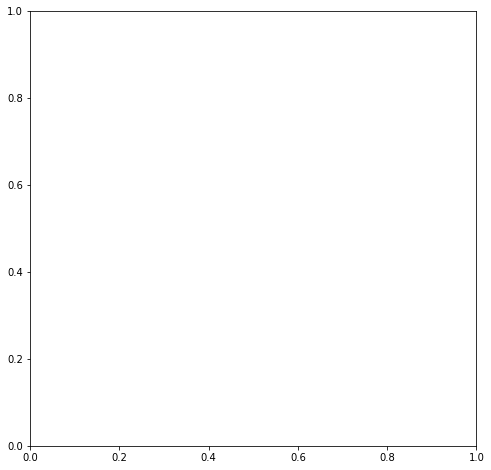

In [36]:
wavefunc = lambda x, y, t: iterative_2D_superpos(HO_Eigenstate_2D, x, y, t, coeff_less, qn_less)
x_range = [0, 1]
y_range = [0, 1]
t_range = [0, Superpos_Period(HO_Eigenstate_2D_Energy, qn_less)]
print(t_range[1])
acc = 1/im.size[0]
plot_options = {
    "title": r"$\Psi_{cat}$",
    "figsize-factor": 8,
    "axis-on": True, 
    "xlabel": r"$x/L_x$",
    "ylabel": r"$y/L_y$",
    "colorbar": True,
    "axis-on": False,
    "norm_by_frame": True
}
anim_options = {
    "filename": "catwave.mp4",
    "frames": 1,
    "fps": 30,
    "dpi": 200
}

Wavefunction_Animation_2D_Image(wavefunc, acc, x_range, y_range, t_range, plot_options, anim_options)

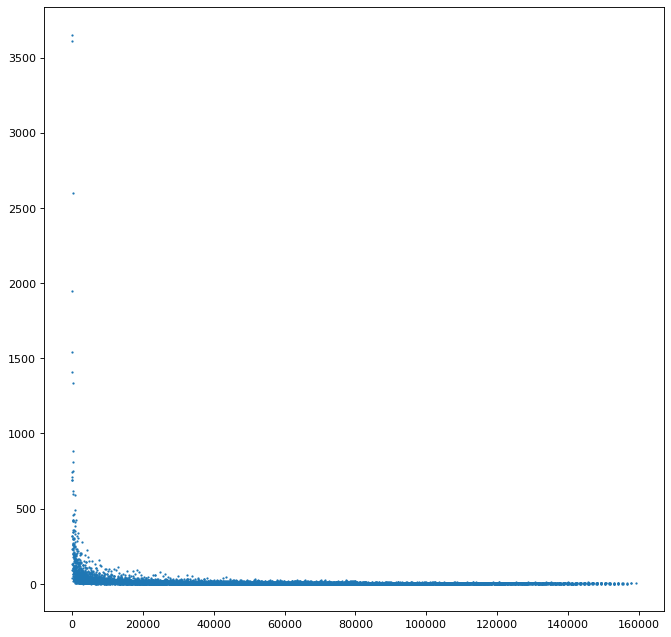

In [56]:
xs = [ISW_Eigenstate_2D_Energy(n,m) for n,m in qn]
ys = [np.abs(c) for c in coeff]

plt.figure(figsize=(10,10), dpi=80)
plt.scatter(xs, ys, s=1)
plt.show()